In [1531]:
!pip install pycountry_convert 
!pip install folium
!pip install seaborn
!pip install plotly

In [1532]:
#Importing the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import plotly.graph_objs as go
import json
import plotly.offline as py
import seaborn as sns
plt.style.use('fivethirtyeight')

In [1533]:
# Global Data
confirmed1_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths1_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries1_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [1534]:
# Because data of recovered cases hasn't been updated so only take first 550 days since 1/22/20

confirmed_df = confirmed1_df.iloc[:,:550]
deaths_df = deaths1_df.iloc[:,:550]
recoveries_df = recoveries1_df.iloc[:,:550]

In [1535]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,133578,134653,135889,136643,137853,139051,140224,140602,141499,142414
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,132592,132597,132608,132616,132629,132647,132665,132686,132697,132740
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,146064,146942,147883,148797,149906,151103,152210,153309,154486,155784
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,14075,14155,14167,14167,14239,14273,14273,14273,14359,14379
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,39958,40055,40138,40327,40530,40631,40707,40805,40906,41061


In [1536]:
deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,5724,5791,5849,5923,5983,6072,6098,6147,6213,6266
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,2456,2456,2456,2456,2456,2456,2456,2456,2456,2456
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,3836,3851,3867,3882,3895,3910,3922,3938,3956,3979
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,127,127,127,127,127,127,127,127,127,127
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,935,939,941,946,951,952,954,957,969,970


In [1537]:
recoveries_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,81077,82586,82586,82586,82586,82586,82586,82586,82586,82586
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,130050,130052,130053,130059,130061,130067,130072,130074,130081,130086
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,101430,102010,102594,103192,103809,104397,104992,105604,106337,107041
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,13770,13787,13796,13796,13829,13844,13844,13844,13897,13930
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,34327,34357,34500,34584,34620,34724,34732,34755,34790,34857


# Problem 1: Calculate the number of total cases, total deaths, total recovered, and total active until date

In [1538]:
cols = confirmed_df.keys()
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:,cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:,cols[4]:cols[-1]]
dates = confirmed.keys()
adjusted_dates = list(np.array([i for i in range(len(dates))]).reshape(-1, 1)[:, 0])

In [1539]:
#Total cases confirmed
total_cases_confirmed = confirmed_df.iloc[:,-1].sum()
print("Total confirmed cases: ", total_cases_confirmed)

Total confirmed cases:  191973288


In [1540]:
#Total deaths
total_death_cases = deaths_df.iloc[:,-1].sum()
print("Total death cases: ", total_death_cases)

Total death cases:  4118607


In [1541]:
#Total recoveries
total_recoveries_cases = recoveries_df.iloc[:,-1].sum()
print("Total recoveries cases: ", total_recoveries_cases)

Total recoveries cases:  126008997


In [1542]:
#Total active cases
total_active_cases = total_cases_confirmed - total_death_cases - total_recoveries_cases
print("Total active cases: ", total_active_cases)

Total active cases:  61845684


# Problem 2: Visualize the number and the log(10) of total cases, total deaths, total recovered, and total active by time (day units) in 2 graph (one for the number and the other for the log(10)) using line chart.

### Visualize the number

In [1543]:
# Data

In [1544]:
adjusted_dates = list(np.array([i for i in range(len(dates))]).reshape(-1, 1)[:, 0])

In [1545]:
confirmed.columns = adjusted_dates
confirmed.loc['total_cases'] = confirmed.sum(axis=0)
confirmed.tail()

,0,1,2,3,4,5,6,7,8,9,...,536,537,538,539,540,541,542,543,544,545
280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
281,0,0,0,0,0,0,0,0,0,0,...,6948,6952,6961,6964,6967,6972,6977,6981,6987,6992
282,0,0,0,0,0,0,0,0,0,0,...,175729,176742,178748,180549,182129,183344,184672,185649,186279,187602
283,0,0,0,0,0,0,0,0,0,0,...,67765,70426,73271,76381,78872,81168,82613,83619,85732,88415
total_cases,557,657,944,1437,2120,2929,5580,6169,8237,9927,...,187373967,187806218,188332185,188870134,189446580,190042600,190533118,190954432,191440725,191973288


In [1546]:
deaths.columns = adjusted_dates
deaths.loc['total_deaths'] = deaths.sum(axis=0)
deaths.tail()

,0,1,2,3,4,5,6,7,8,9,...,536,537,538,539,540,541,542,543,544,545
280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
281,0,0,0,0,0,0,0,0,0,0,...,1366,1366,1366,1366,1366,1366,1368,1368,1370,1371
282,0,0,0,0,0,0,0,0,0,0,...,2822,2867,2904,2949,2991,3022,3052,3084,3113,3138
283,0,0,0,0,0,0,0,0,0,0,...,2185,2236,2274,2332,2418,2520,2588,2622,2697,2747
total_deaths,17,18,26,42,56,82,131,133,171,213,...,4034264,4042328,4050711,4059318,4067943,4076686,4084203,4090742,4097881,4118607


In [1547]:
recoveries.columns = adjusted_dates
recoveries.loc['total_recovered'] = recoveries.sum(axis=0)
recoveries.tail()

,0,1,2,3,4,5,6,7,8,9,...,536,537,538,539,540,541,542,543,544,545
265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
266,0,0,0,0,0,0,0,0,0,0,...,4141,4142,4147,4151,4154,4154,4156,4159,4162,4162
267,0,0,0,0,0,0,0,0,0,0,...,160215,162239,163681,164924,166388,168052,169320,171699,173320,174728
268,0,0,0,0,0,0,0,0,0,0,...,45617,46932,48102,49053,49774,51139,51923,53453,55714,58155
total_recovered,30,32,39,42,56,65,108,127,145,225,...,123197639,123499875,123783322,124113063,124394119,124784824,125065613,125382096,125688817,126008997


In [1548]:
total_table = pd.concat([confirmed.loc['total_cases'],deaths.loc['total_deaths'],recoveries.loc['total_recovered']], axis=1)
total_table

,total_cases,total_deaths,total_recovered
0,557,17,30
1,657,18,32
2,944,26,39
3,1437,42,42
4,2120,56,56
...,...,...,...
541,190042600,4076686,124784824
542,190533118,4084203,125065613
543,190954432,4090742,125382096
544,191440725,4097881,125688817


In [1549]:
total_table['total_active'] = total_table.total_cases - total_table.total_deaths - total_table.total_recovered
total_table.index.name = 'Day'
total_table

,total_cases,total_deaths,total_recovered,total_active
Day,,,,
0,557,17,30,510
1,657,18,32,607
2,944,26,39,879
3,1437,42,42,1353
4,2120,56,56,2008
...,...,...,...,...
541,190042600,4076686,124784824,61181090
542,190533118,4084203,125065613,61383302
543,190954432,4090742,125382096,61481594


In [1550]:
# Visualization

<function matplotlib.pyplot.show(close=None, block=None)>

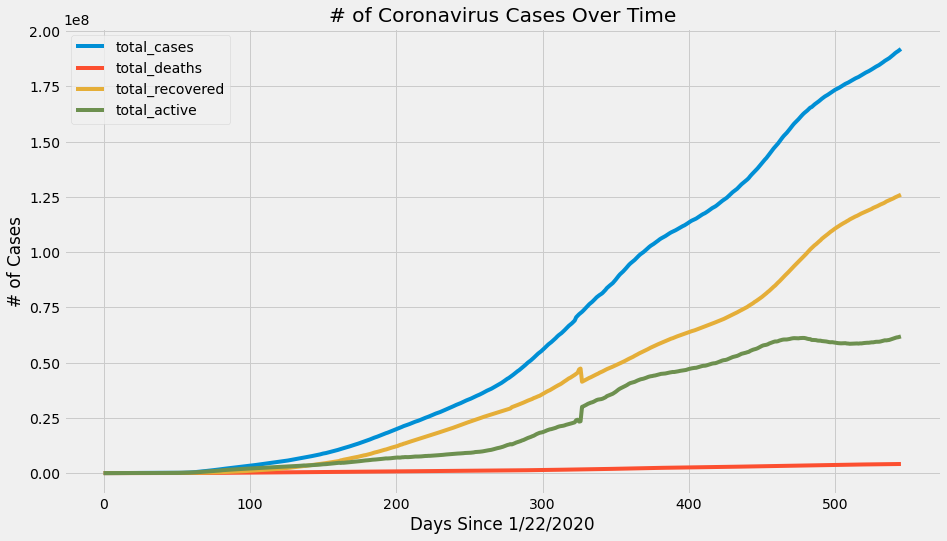

In [1551]:
total_table.plot(kind='line', figsize=(14,8))
plt.title('# of Coronavirus Cases Over Time')
plt.ylabel('# of Cases')
plt.xlabel('Days Since 1/22/2020')
plt.show

### Visualize the log(10)

In [1552]:
log10_total_table = np.log10(total_table)
log10_total_table

,total_cases,total_deaths,total_recovered,total_active
Day,,,,
0,2.745855,1.230449,1.477121,2.707570
1,2.817565,1.255273,1.505150,2.783189
2,2.974972,1.414973,1.591065,2.943989
3,3.157457,1.623249,1.623249,3.131298
4,3.326336,1.748188,1.748188,3.302764
...,...,...,...,...
541,8.278851,6.610307,8.096162,7.786617
542,8.279970,6.611107,8.097138,7.788050
543,8.280930,6.611802,8.098236,7.788745


<function matplotlib.pyplot.show(close=None, block=None)>

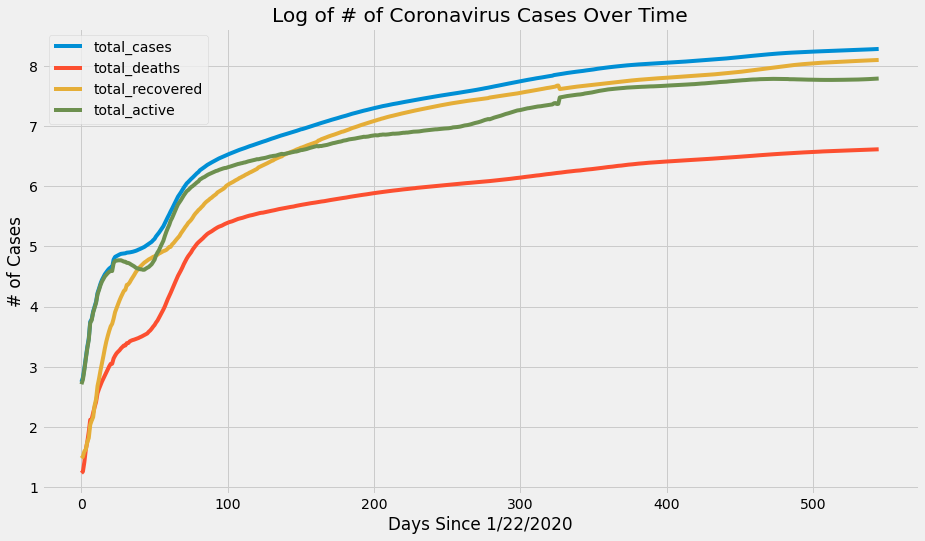

In [1553]:
log10_total_table.plot(kind='line', figsize=(14,8))
plt.title('Log of # of Coronavirus Cases Over Time')
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('# of Cases')
plt.show

# Problem 3: Visualize the number of total cases, total deaths, total recovered, and total active by time (day units) in 4 separated graphs using line chart

In [1554]:
# Number of total cases

<function matplotlib.pyplot.show(close=None, block=None)>

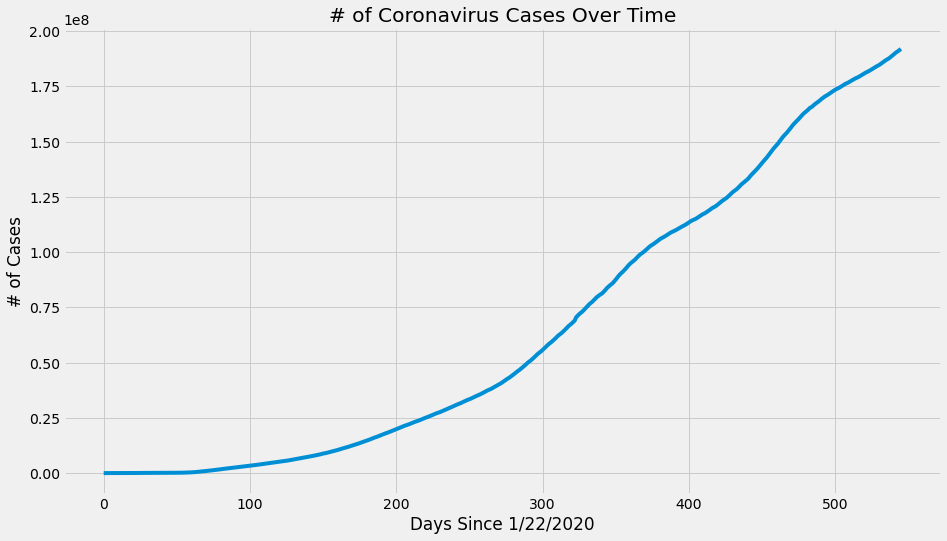

In [1555]:
total_table.iloc[:,0].plot(kind='line', figsize=(14,8))
plt.title('# of Coronavirus Cases Over Time')
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('# of Cases')
plt.show

In [1556]:
# Number of total deaths

<function matplotlib.pyplot.show(close=None, block=None)>

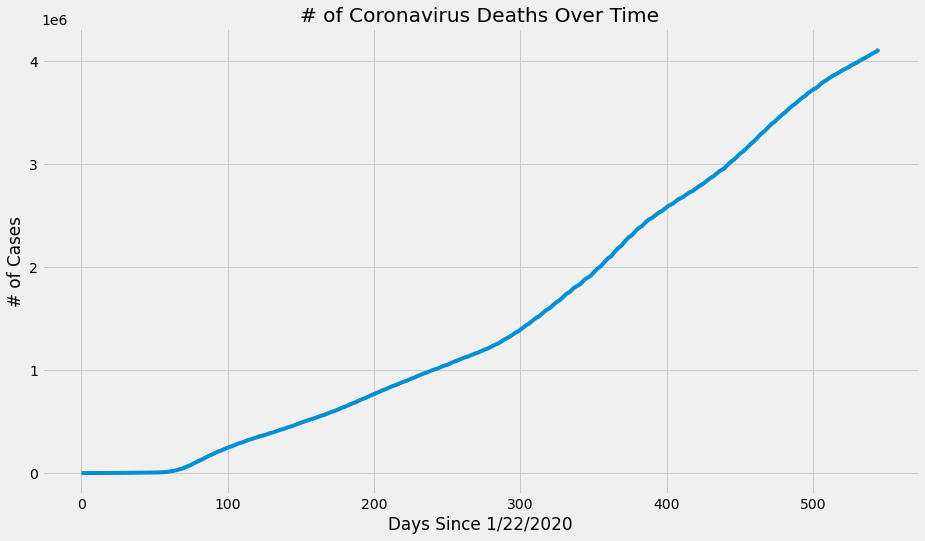

In [1557]:
total_table.iloc[:,1].plot(kind='line', figsize=(14,8))
plt.title('# of Coronavirus Deaths Over Time')
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('# of Cases')
plt.show

In [1558]:
# Number of total recoveries

<function matplotlib.pyplot.show(close=None, block=None)>

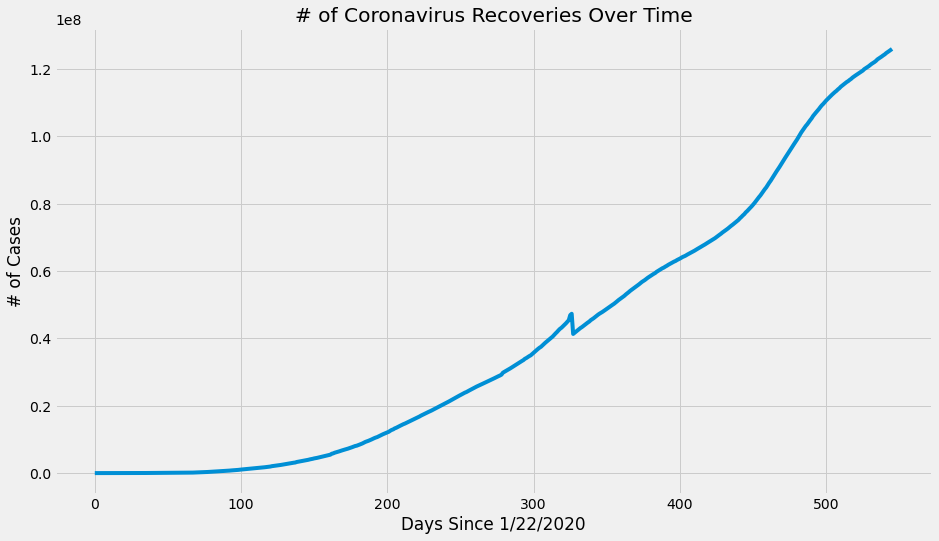

In [1559]:
total_table.iloc[:,2].plot(kind='line', figsize=(14,8))
plt.title('# of Coronavirus Recoveries Over Time')
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('# of Cases')
plt.show

In [1560]:
# Number of total active cases

<function matplotlib.pyplot.show(close=None, block=None)>

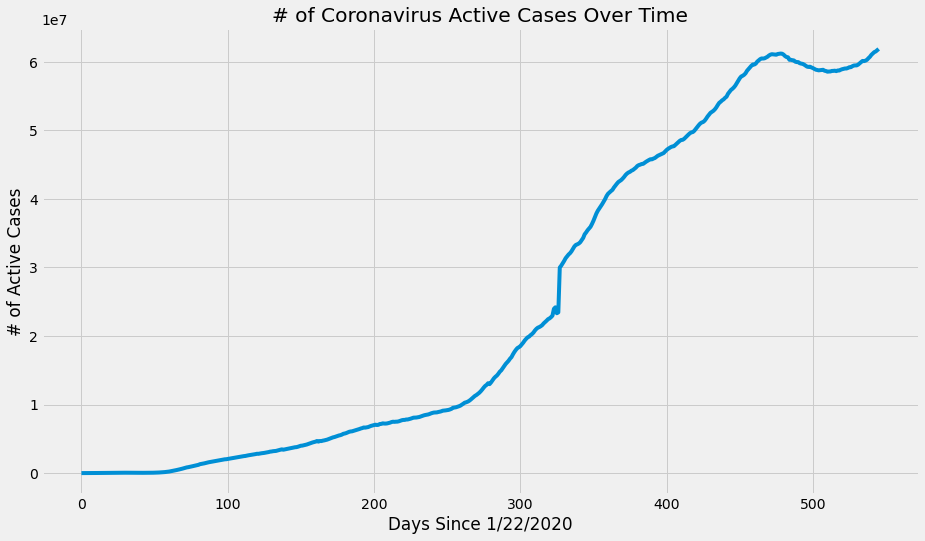

In [1561]:
total_table.iloc[:,3].plot(kind='line', figsize=(14,8))
plt.title('# of Coronavirus Active Cases Over Time')
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('# of Active Cases')
plt.show

# Problem 6: Calculate the global mortality and recovered rate in percentage by time.

In [1562]:
global_mortality_rate = (total_death_cases / total_cases_confirmed)*100
print('The global mortality rate by time is {}%'.format(round(global_mortality_rate,1)))

The global mortality rate by time is 2.1%


In [1563]:
global_recovered_rate = (total_recoveries_cases / total_cases_confirmed)*100
print('The recovered rate by time is {}%'.format(round(global_recovered_rate,1)))

The recovered rate by time is 65.6%


# Problem 7.1: Visualize the mortality rate in by time (day units) using the line chart.

Using the dashline to visualize the average mortality rate of all the time.

In [1564]:
total_table['mortality_rate'] = (total_table['total_deaths'] / total_table['total_cases'])*100
total_table['recovered_rate'] = (total_table['total_recovered'] / total_table['total_cases'])*100
total_table['average_mortality_rate'] =  total_table['mortality_rate'].mean()
total_table['average_recovered_rate'] =  total_table['recovered_rate'].mean()
total_table

,total_cases,total_deaths,total_recovered,total_active,mortality_rate,recovered_rate,average_mortality_rate,average_recovered_rate
Day,,,,,,,,
0,557,17,30,510,3.052065,5.385996,3.393031,52.377719
1,657,18,32,607,2.739726,4.870624,3.393031,52.377719
2,944,26,39,879,2.754237,4.131356,3.393031,52.377719
3,1437,42,42,1353,2.922756,2.922756,3.393031,52.377719
4,2120,56,56,2008,2.641509,2.641509,3.393031,52.377719
...,...,...,...,...,...,...,...,...
541,190042600,4076686,124784824,61181090,2.145143,65.661501,3.393031,52.377719
542,190533118,4084203,125065613,61383302,2.143566,65.639829,3.393031,52.377719
543,190954432,4090742,125382096,61481594,2.142261,65.660742,3.393031,52.377719


<function matplotlib.pyplot.show(close=None, block=None)>

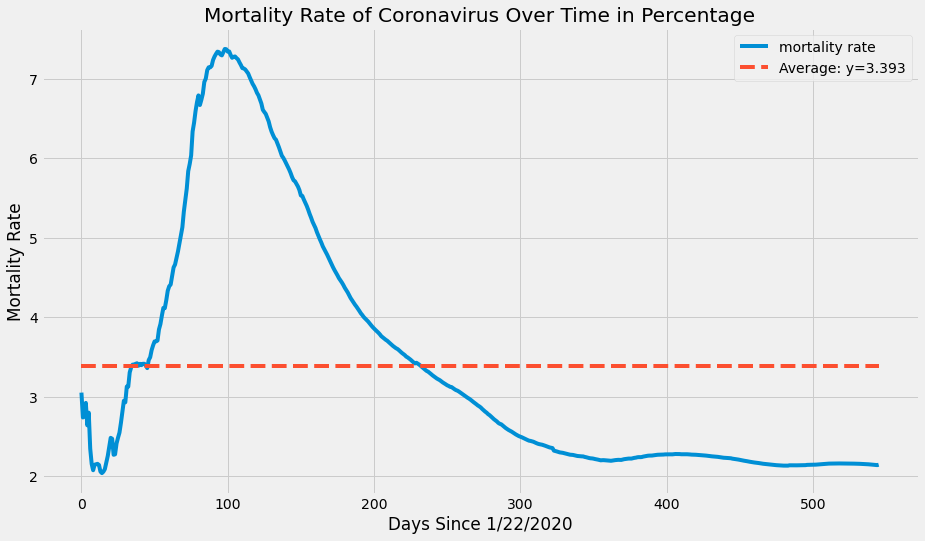

In [1565]:
plt.figure(figsize=[14,8])
plt.plot(total_table.loc[:,['mortality_rate']], label='mortality rate')
plt.plot(total_table.loc[:,['average_mortality_rate']], label='Average: y=3.393', linestyle='dashed')
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('Mortality Rate')
plt.title('Mortality Rate of Coronavirus Over Time in Percentage')
plt.legend()
plt.show

# Problem 7.2

Visualize the recovered rate in by time (day units) using the line chart.

Using the dashline to visualize the average recovered rate of all the time.

<function matplotlib.pyplot.show(close=None, block=None)>

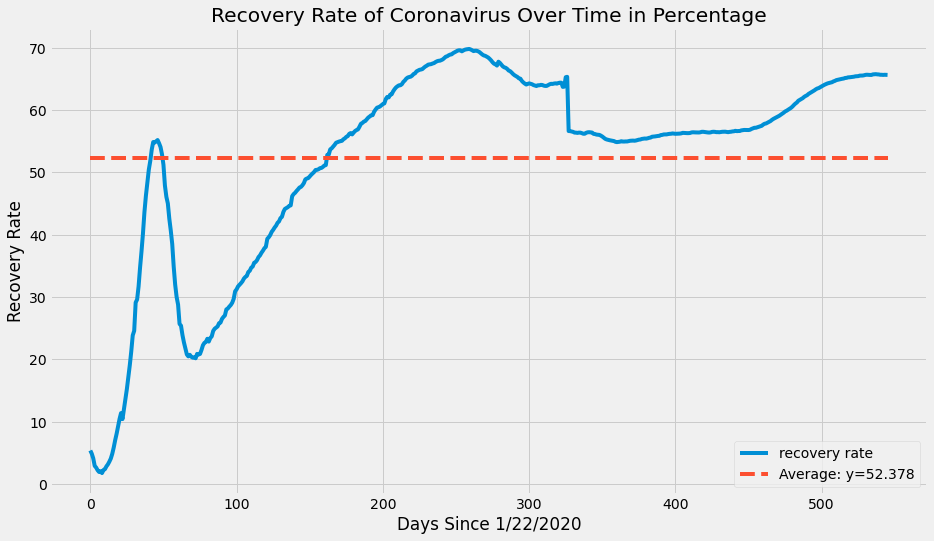

In [1566]:
plt.figure(figsize=[14,8])
plt.plot(total_table.loc[:,['recovered_rate']], label='recovery rate')
plt.plot(total_table.loc[:,['average_recovered_rate']], label='Average: y=52.378', linestyle='dashed')
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('Recovery Rate')
plt.title('Recovery Rate of Coronavirus Over Time in Percentage')
plt.legend(loc='lower right')
plt.show

# Problem 8: Add the field "continent" into the confirm_df, deaths_df and recorveries_df dataset

In [1567]:
# Changing the conuntry names as required by pycountry_convert Lib
confirmed_df.loc[confirmed_df['Country/Region'] == "US", "Country/Region"] = "USA"
deaths_df.loc[deaths_df['Country/Region'] == "US", "Country/Region"] = "USA"
recoveries_df.loc[recoveries_df['Country/Region'] == "US", "Country/Region"] = "USA"

confirmed_df.loc[confirmed_df['Country/Region'] == 'Korea, South', "Country/Region"] = 'South Korea'
deaths_df.loc[deaths_df['Country/Region'] == 'Korea, South', "Country/Region"] = 'South Korea'
recoveries_df.loc[recoveries_df['Country/Region'] == "Korea, South", "Country/Region"] = "South Korea"

confirmed_df.loc[confirmed_df['Country/Region'] == 'Taiwan*', "Country/Region"] = 'Taiwan'
deaths_df.loc[deaths_df['Country/Region'] == 'Taiwan*', "Country/Region"] = 'Taiwan'
recoveries_df.loc[recoveries_df['Country/Region'] == "Taiwan*", "Country/Region"] = "Taiwan"

confirmed_df.loc[confirmed_df['Country/Region'] == 'Congo (Kinshasa)', "Country/Region"] = 'Democratic Republic of the Congo'
deaths_df.loc[deaths_df['Country/Region'] == 'Congo (Kinshasa)', "Country/Region"] = 'Democratic Republic of the Congo'
recoveries_df.loc[recoveries_df['Country/Region'] == "Congo (Kinshasa)", "Country/Region"] = "Democratic Republic of the Congo"

confirmed_df.loc[confirmed_df['Country/Region'] == "Cote d'Ivoire", "Country/Region"] = "Côte d'Ivoire"
deaths_df.loc[deaths_df['Country/Region'] == "Cote d'Ivoire", "Country/Region"] = "Côte d'Ivoire"
recoveries_df.loc[recoveries_df['Country/Region'] == "Cote d'Ivoire", "Country/Region"] = "Côte d'Ivoire"

confirmed_df.loc[confirmed_df['Country/Region'] == "Reunion", "Country/Region"] = "Réunion"
deaths_df.loc[deaths_df['Country/Region'] == "Reunion", "Country/Region"] = "Réunion"
recoveries_df.loc[recoveries_df['Country/Region'] == "Reunion", "Country/Region"] = "Réunion"

confirmed_df.loc[confirmed_df['Country/Region'] == 'Congo (Brazzaville)', "Country/Region"] = 'Republic of the Congo'
deaths_df.loc[deaths_df['Country/Region'] == 'Congo (Brazzaville)', "Country/Region"] = 'Republic of the Congo'
recoveries_df.loc[recoveries_df['Country/Region'] == "Congo (Brazzaville)", "Country/Region"] = "Republic of the Congo"

confirmed_df.loc[confirmed_df['Country/Region'] == 'Bahamas, The', "Country/Region"] = 'Bahamas'
deaths_df.loc[deaths_df['Country/Region'] == 'Bahamas, The', "Country/Region"] = 'Bahamas'
recoveries_df.loc[recoveries_df['Country/Region'] == "Bahamas, The", "Country/Region"] = "Bahamas"

confirmed_df.loc[confirmed_df['Country/Region'] == 'Gambia, The', "Country/Region"] = 'Gambia'
deaths_df.loc[deaths_df['Country/Region'] == 'Gambia, The', "Country/Region"] = 'Gambia'
recoveries_df.loc[recoveries_df['Country/Region'] == "Gambia, The", "Country/Region"] = "Gambia"

# getting all countries
countries = np.asarray(confirmed_df["Country/Region"])
countries1 = np.asarray(deaths_df["Country/Region"])
countries2 = np.asarray(recoveries_df["Country/Region"])

# Continent_code to Continent_names
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

# Defininng Function for getting continent code for country.
def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'


In [1568]:
confirmed_df.insert(2,'continent',[continents[country_to_continent_code(i)] for i in countries])
deaths_df.insert(2,'continent',[continents[country_to_continent_code(i)] for i in countries1])
recoveries_df.insert(2,'continent',[continents[country_to_continent_code(i)] for i in countries2])

In [1569]:
confirmed_df.head()

,Province/State,Country/Region,continent,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21
0,NaN,Afghanistan,Asia,33.93911,67.709953,0,0,0,0,0,...,133578,134653,135889,136643,137853,139051,140224,140602,141499,142414
1,NaN,Albania,Europe,41.15330,20.168300,0,0,0,0,0,...,132592,132597,132608,132616,132629,132647,132665,132686,132697,132740
2,NaN,Algeria,Africa,28.03390,1.659600,0,0,0,0,0,...,146064,146942,147883,148797,149906,151103,152210,153309,154486,155784
3,NaN,Andorra,Europe,42.50630,1.521800,0,0,0,0,0,...,14075,14155,14167,14167,14239,14273,14273,14273,14359,14379
4,NaN,Angola,Africa,-11.20270,17.873900,0,0,0,0,0,...,39958,40055,40138,40327,40530,40631,40707,40805,40906,41061


In [1570]:
deaths_df.head()

,Province/State,Country/Region,continent,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21
0,NaN,Afghanistan,Asia,33.93911,67.709953,0,0,0,0,0,...,5724,5791,5849,5923,5983,6072,6098,6147,6213,6266
1,NaN,Albania,Europe,41.15330,20.168300,0,0,0,0,0,...,2456,2456,2456,2456,2456,2456,2456,2456,2456,2456
2,NaN,Algeria,Africa,28.03390,1.659600,0,0,0,0,0,...,3836,3851,3867,3882,3895,3910,3922,3938,3956,3979
3,NaN,Andorra,Europe,42.50630,1.521800,0,0,0,0,0,...,127,127,127,127,127,127,127,127,127,127
4,NaN,Angola,Africa,-11.20270,17.873900,0,0,0,0,0,...,935,939,941,946,951,952,954,957,969,970


In [1571]:
recoveries_df.head()

,Province/State,Country/Region,continent,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21
0,NaN,Afghanistan,Asia,33.93911,67.709953,0,0,0,0,0,...,81077,82586,82586,82586,82586,82586,82586,82586,82586,82586
1,NaN,Albania,Europe,41.15330,20.168300,0,0,0,0,0,...,130050,130052,130053,130059,130061,130067,130072,130074,130081,130086
2,NaN,Algeria,Africa,28.03390,1.659600,0,0,0,0,0,...,101430,102010,102594,103192,103809,104397,104992,105604,106337,107041
3,NaN,Andorra,Europe,42.50630,1.521800,0,0,0,0,0,...,13770,13787,13796,13796,13829,13844,13844,13844,13897,13930
4,NaN,Angola,Africa,-11.20270,17.873900,0,0,0,0,0,...,34327,34357,34500,34584,34620,34724,34732,34755,34790,34857


# Problem 9: Create the countries_df data frame with the index as the "Country/Region" field.
These column infor will be: 
- continent: Country continent.
- Deaths: Total number of confirmed.
- Deaths: Total number of deaths.
- Recoveries: Total number of recoveries.
- Active: Total number of active.
- Mortality Rate: Mortality rate in percentage.

In [1572]:
# Slice table & name it 'countries_df'
countries_df = confirmed_df[['Country/Region','Lat','Long','continent']]
countries_df

,Country/Region,Lat,Long,continent
0,Afghanistan,33.939110,67.709953,Asia
1,Albania,41.153300,20.168300,Europe
2,Algeria,28.033900,1.659600,Africa
3,Andorra,42.506300,1.521800,Europe
4,Angola,-11.202700,17.873900,Africa
...,...,...,...,...
279,West Bank and Gaza,31.952200,35.233200,Others
280,Winter Olympics 2022,39.904200,116.407400,Others
281,Yemen,15.552727,48.516388,Asia
282,Zambia,-13.133897,27.849332,Africa


In [1573]:
# Calculation
confirmed_copy = confirmed_df.copy()
confirmed_copy['total'] = confirmed_df.iloc[:,-1]
confirmed_dict = confirmed_copy[['Country/Region','total']].set_index('Country/Region')['total'].to_dict()
countries_df['Confirmed'] = countries_df['Country/Region'].map(confirmed_dict)

deaths_copy = deaths_df.copy()
deaths_copy['total'] = deaths_copy.iloc[:,-1]
deaths_dict = deaths_copy[['Country/Region','total']].set_index('Country/Region')['total'].to_dict()
countries_df['Deaths'] = countries_df['Country/Region'].map(deaths_dict)

recoveries_copy = recoveries_df.copy()
recoveries_copy['total'] = recoveries_copy.iloc[:,-1]
recoveries_dict = recoveries_copy[['Country/Region','total']].set_index('Country/Region')['total'].to_dict()
countries_df['Recoveries'] = countries_df['Country/Region'].map(recoveries_dict)

countries_df['Active'] = countries_df['Confirmed'] - countries_df['Deaths'] - countries_df['Recoveries']

countries_df['Mortality Rate'] = round((countries_df['Deaths'] / countries_df['Confirmed'])*100,2)

countries_df.set_index('Country/Region').head()

C:\Users\DELL\AppData\Local\Temp/ipykernel_17708/3937560647.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\DELL\AppData\Local\Temp/ipykernel_17708/3937560647.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\DELL\AppData\Local\Temp/ipykernel_17708/3937560647.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,Lat,Long,continent,Confirmed,Deaths,Recoveries,Active,Mortality Rate
Country/Region,,,,,,,,
Afghanistan,33.93911,67.709953,Asia,142414,6266,82586,53562,4.40
Albania,41.15330,20.168300,Europe,132740,2456,130086,198,1.85
Algeria,28.03390,1.659600,Africa,155784,3979,107041,44764,2.55
Andorra,42.50630,1.521800,Europe,14379,127,13930,322,0.88
Angola,-11.20270,17.873900,Africa,41061,970,34857,5234,2.36


# Problem 10: Create the continents_df data frame with the index as the "continent" field.
These column infor will be: 
- Confirmed: Country continent.
- Deaths: Total number of deaths.
- Recoveries: Total number of recoveries.
- Active: Total number of active.
- Mortality Rate: Mortality rate in percentage.

In [1574]:
continents_df = countries_df.drop(['Lat','Long','Mortality Rate'],1).groupby(['continent']).sum()
continents_df['Mortality Rate'] = round((continents_df['Deaths'] / continents_df['Confirmed'])*100,2)
continents_df.head()

C:\Users\DELL\AppData\Local\Temp/ipykernel_17708/1819395629.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



,Confirmed,Deaths,Recoveries,Active,Mortality Rate
continent,,,,,
Africa,6296294,159664,5462574,674056,2.54
Asia,58882809,842352,55250766,2789691,1.43
Australia,50925,441,35085,15399,0.87
Europe,194004903,4086925,31699004,158218974,2.11
North America,39292076,883670,26365088,12043318,2.25


# Problem 12: Visualize the covariance matrix for continents_df.

In [1575]:
continents_df.corr()

,Confirmed,Deaths,Recoveries,Active,Mortality Rate
Confirmed,1.000000,0.988856,0.519235,0.954979,0.130393
Deaths,0.988856,1.000000,0.465286,0.960593,0.229900
Recoveries,0.519235,0.465286,1.000000,0.242328,0.177831
Active,0.954979,0.960593,0.242328,1.000000,0.083668
Mortality Rate,0.130393,0.229900,0.177831,0.083668,1.000000


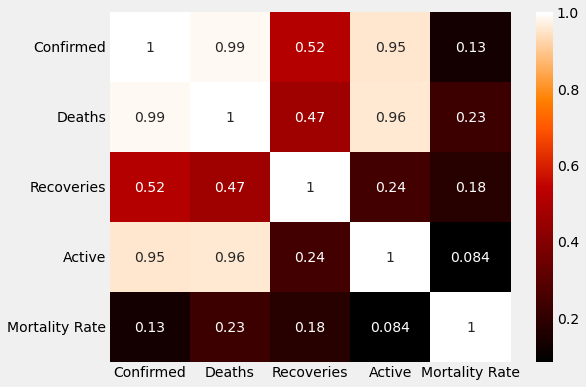

In [1576]:
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap="gist_heat",annot=True)
plt.show()

# Problem 13:
Build the pie chart to compare proportions of the number of confirmed, deaths, recoveries, and active of the 7 continents.
Each field (confirm, deaths, ...) should be presented in different pie charts.
You are not allowed to use repeated code snippet here, let try to use a for loop.
Each continent should be presented in different colors.

In [1577]:
colors_list = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FFFF33', '#A65628','#F781BF']

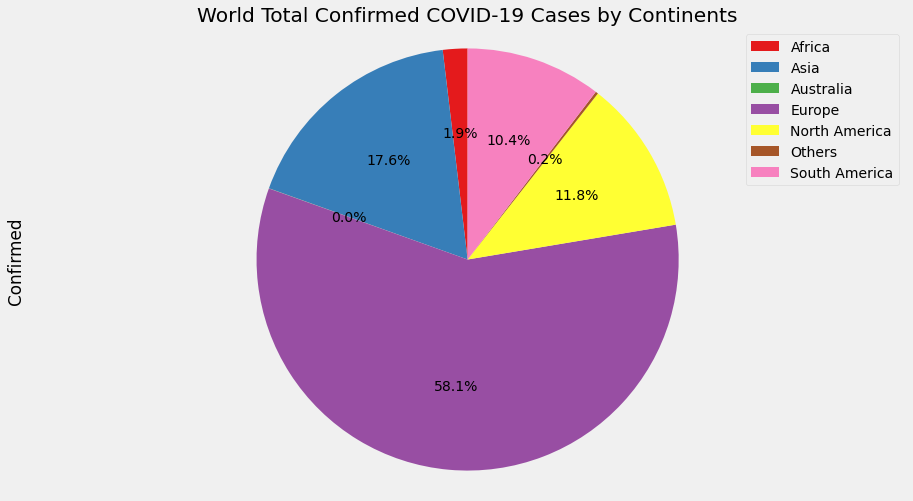

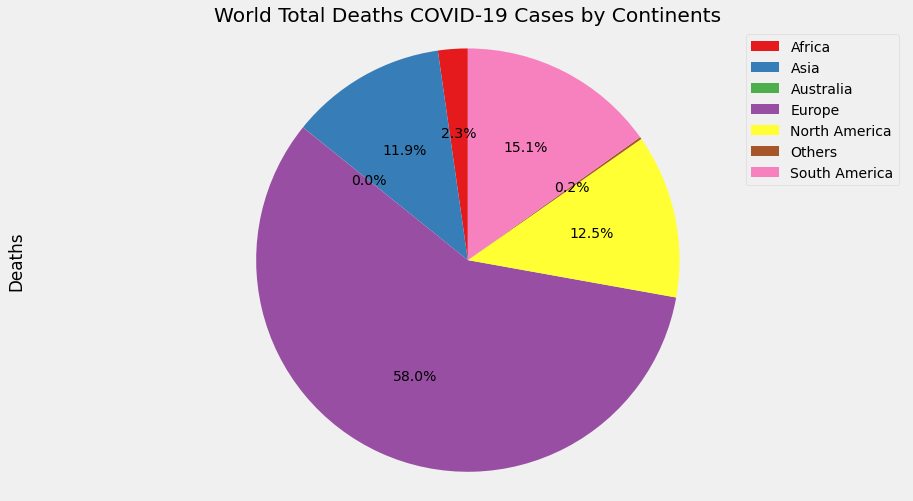

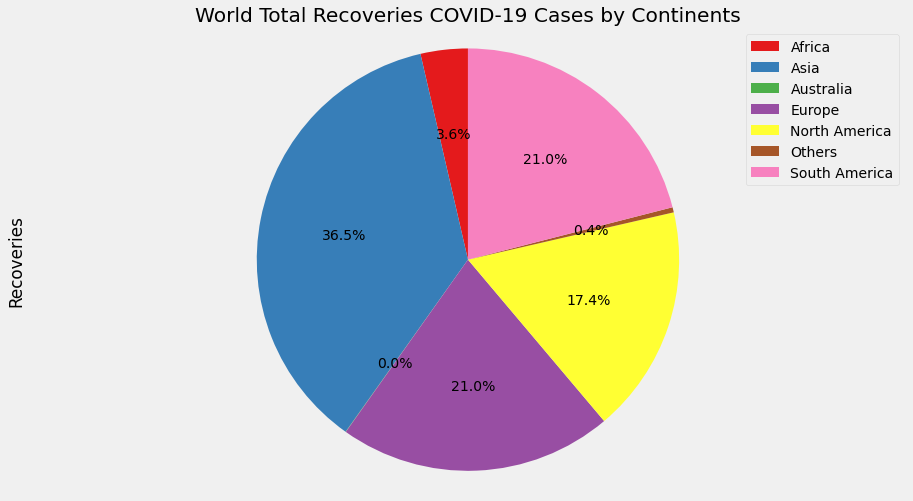

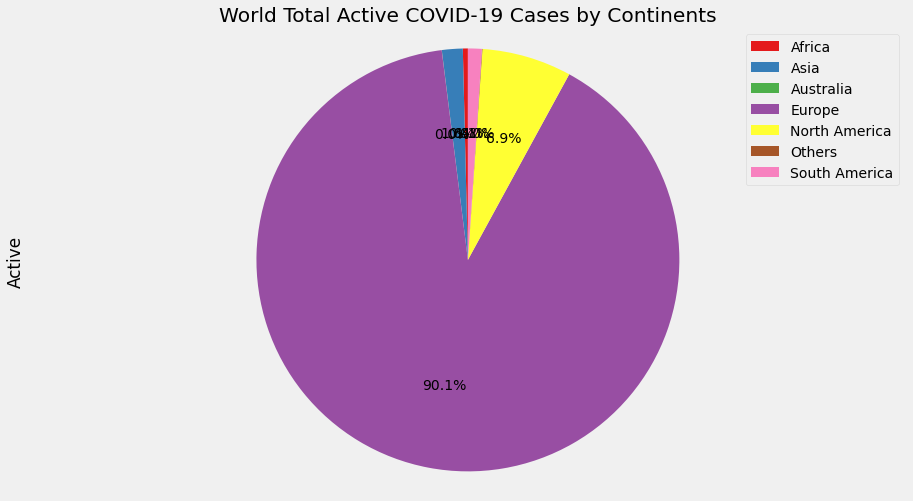

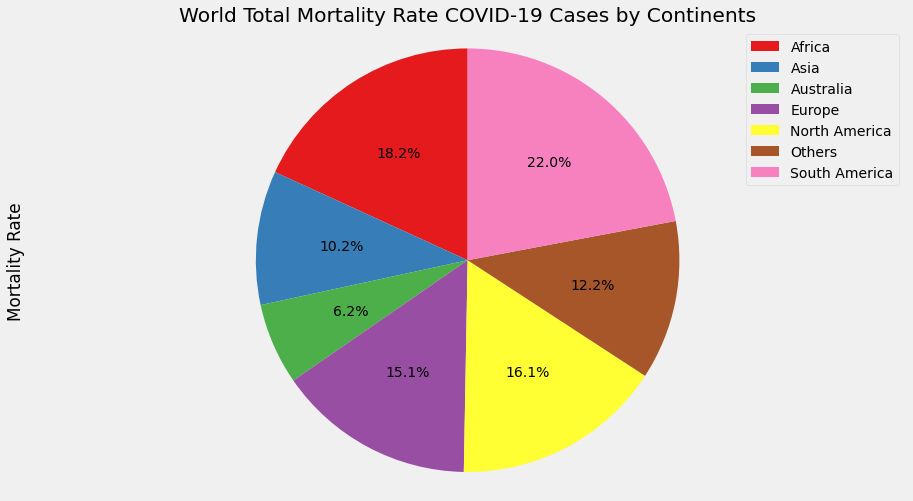

In [1578]:
i = 0

for i in continents_df.columns:
    continents_df.loc[:,i].plot(kind='pie',
                            figsize=(14,8),
                            autopct='%1.1f%%',
                            startangle=90,
                            labels=None,
                            colors=colors_list
                            )

    plt.title('World Total {} COVID-19 Cases by Continents'.format(i))
    plt.axis('equal')
    plt.legend(labels=continents_df.index, loc='upper right')
    plt.show()

# Problem 14: Build a folium map to show up the number of confirmed, deaths, recovered and mortality rate of each country based on countries' location. The radius of the cicle is proportional to the number of confirmed.

In [1579]:
# Data
countries_df.dropna(subset=['Lat','Long'], axis=0, inplace=True)
countries_df.reset_index(drop=True, inplace=True)

C:\Users\DELL\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1580]:
# Draw map
global_map = folium.Map(location=[20,0], zoom_start=2)
global_map

In [1581]:
countries_cases = folium.map.FeatureGroup()

for row in countries_df.itertuples():
    countries_cases.add_child(
        folium.features.CircleMarker(
            location=[row.Lat,row.Long],
            radius=(row.Confirmed / countries_df['Confirmed'].max())*50,
            color='#FF6600',
            fill=True,
            fill_color='#FF6600',
            fill_opacity=0.1            ))
    
global_map.add_child(countries_cases)

# Problem 16: Filter the top 10 countries based on the number of confirmed cases.

In [1582]:
countries_df = countries_df.groupby('Country/Region').mean()
countries_df.sort_values(['Confirmed'], ascending=False, axis=0, inplace=True)
countries4 = np.asarray(countries_df.index)
countries_df.insert(2,'continent',[continents[country_to_continent_code(i)] for i in countries4])
df_top10 = countries_df.head(10)
df_top10.head(10)

,Lat,Long,continent,Confirmed,Deaths,Recoveries,Active,Mortality Rate
Country/Region,,,,,,,,
USA,40.000000,-100.000000,North America,34293068.0,605583.0,0.0,33687485.0,1.77
India,20.593684,78.962880,Asia,31216337.0,418480.0,30390687.0,407170.0,1.34
Brazil,-14.235000,-51.925300,South America,19428736.0,544532.0,17371065.0,1513139.0,2.80
Russia,61.524010,105.318756,Europe,5931925.0,147457.0,5318062.0,466406.0,2.49
France,6.425300,-9.839634,Europe,5814442.0,110548.0,340769.0,5363125.0,1.90
Turkey,38.963700,35.243300,Asia,5546166.0,50650.0,5395300.0,100216.0,0.91
United Kingdom,25.767514,-35.857561,Europe,5519602.0,128823.0,0.0,5390779.0,2.33
Argentina,-38.416100,-63.616700,South America,4784219.0,102381.0,4420995.0,260843.0,2.14
Colombia,4.570900,-74.297300,South America,4668750.0,117131.0,4422866.0,128753.0,2.51


# Problem 17: Visualize the top 10 confirmed countries with number active, recoveries and deaths cases using the stacked bar chart.

<AxesSubplot:title={'center':'The Top 10 Confirmed Countries'}, xlabel='Country/Region'>

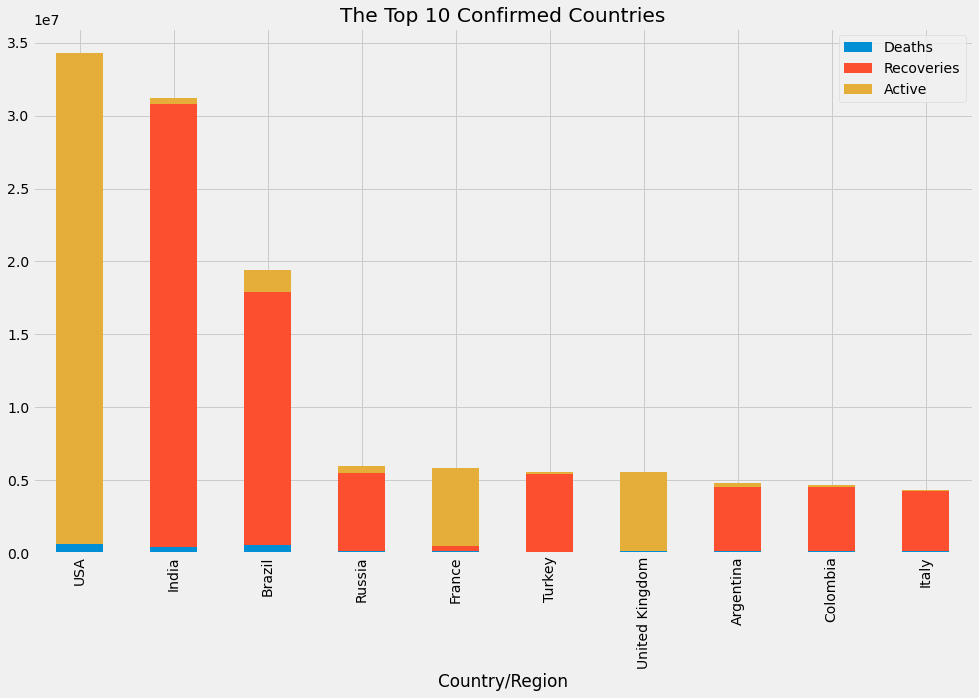

In [1583]:
df_top10_new = df_top10.reset_index()
df = df_top10_new[['Country/Region','Deaths','Recoveries','Active']]
df.plot(x='Country/Region', kind='bar', stacked=True,
        title='The Top 10 Confirmed Countries')